Многокритериальная задача оптимизации инвестиций с учетом риска.

Допустим, у нас есть инвестиционный портфель, и мы хотим распределить средства между несколькими инвестиционными инструментами с целью максимизации доходности при минимизации риска.

Цели:

- Максимизировать ожидаемую доходность инвестиционного портфеля.
- Минимизировать общий риск портфеля.

Ограничения:

- У нас есть несколько инвестиционных инструментов (например, акции, облигации, драгоценные металлы, недвижимость, криптовалюты), каждый из которых имеет свою ожидаемую доходность и уровень риска.
- Есть ограничение на объем инвестиций на бирже без дополнительных аутенфикаций (акции, облигации, драгоценные металлы)
- Есть ограничение по сумме вложений на криптовалютную биржу
- Можно взять в долг у банка сумму не больше заданной и вложить в недвижимость, но надо будет вернуть через год с 20% годовых
- Также у нас есть ограничение на общую сумму средств, которые мы можем инвестировать без банка.
- Есть ограничение на минимальную доходность

Математическая постановка:
- $x_1$ - акции
- $x_2$ - облигации
- $x_3$ - драгоценные металлы
- $x_4$ - недвижимость
- $x_5$ - криптовалюта
- $x_6$ - кредит банка
- $d_1...d_5$ - проценты доходности
- $r_1...r_5$ - проценты риска

Доходность:
$$x_1*d_1 + x_2*d_2 + x_3*d_3 + x_4*d_4 + x_5*d_5 + x_6*(d_4-0.2) → max$$

Риск:

$$x_1*r_1+x_2*r_2+x_3*r_3+x_4*r_4+x_5*r_5+x_6*r_4 → min $$

Ограничения:
$$\begin{cases}
x_1+x_2+x_3<=MaxStocksInvestments\\
x_5<=MaxCrypto\\
x_6<=MaxBankCredit\\
x_1+x_2+x_3+x_4+x_5<=OurMoney\\
x_1*d_1 + x_2*d_2 + x_3*d_3 + x_4*d_4 + x_5*d_5 + x_6*(d_4-0.2)>=MinIncome \\
x1...x_6>=0
\end{cases}$$





Первой по важности является доходность, потому что мы можем никуда не вкладывать и риск будет минимальным, но мы хотим какую-то доходность. Также при инвестициях мы ожидаем тот или иной уровень риска и готовы идти на больший риск при большей доходности.

In [ ]:
import numpy as np

rng = np.random.default_rng()

# Формируем проценты доходности
d_percents = -rng.integers(low=1, high=100, size=5)/100
d = [i for i in d_percents]
d.append(d[3] + 0.2)
d = np.array(d)

# Формируем проценты риска
r_percents = rng.integers(low=1, high=40, size=5)/100
r = [i for i in r_percents]
r.append(r[3])
r = np.array(r)

# Вариант, когда мы хотим потратить все деньги в заданные инструментыы

# A = [[1, 1, 1, 0, 0, 0],
#      [0, 0, 0, 0, 1, 0],
#      [0, 0, 0, 0, 0, 1],
#      [i for i in d]]
# A_eq = [[1, 1, 1, 1, 1, 0]]
# b_eq = [30_000_000]
# b = [10_000_000, 3_000_000, 6_000_000,  -1_000_000]

# Вариант, когда мы можем потратить меньше денег чем у нас есть
# (остальное допустим вложить без риска по банковской ставке без учета в модели)

A = [[1, 1, 1, 0, 0, 0],
     [0, 0, 0, 0, 1, 0],
     [0, 0, 0, 0, 0, 1],
     [1, 1, 1, 1, 1, 0],
     [i for i in d]]
A_eq = None
b_eq = None
b = [10_000_000, 3_000_000, 6_000_000, 30_000_000, -1_000_000]


In [ ]:
from scipy.optimize import linprog

def scipy_solution(A, b, c, A_eq, b_eq):
  matrix = np.array(A)
  obj = np.array(c)
  rhs_ineq = np.array(b)
  bnds = []

  for _ in range(6):
    bnds.append((0, float("inf")))

  res = linprog(obj, A_ub=matrix, b_ub=rhs_ineq,A_eq=A_eq, b_eq=b_eq, bounds=bnds, method='highs')
  return res

Решения для различных величин уступок, от 0 до 50%

In [ ]:
res = scipy_solution(A, b, d,A_eq, b_eq)
max_income = res.fun
income_arr = []
risk_arr = []
A_u = A[:]
A_u.append(list(d))

for ustupka in range(51):
  b_u = b[:]
  b_u.append(max_income-max_income*ustupka/100)
  res = scipy_solution(A_u, b_u, r,A_eq, b_eq)
  if res.x is None:
    print(ustupka)
    continue
  risk_arr.append(res.fun)
  income_arr.append(-sum(res.x*d))

In [ ]:
def coeff_solve(coef, A, b, d, r, A_eq, b_eq, risk, income):
  risk_coef, income_coef = coef, 1-coef
  res = scipy_solution(A, b, d*income_coef + r*risk_coef, A_eq, b_eq)
  res_risk = sum(res.x*r)
  res_income = -sum(res.x*d)
  return (abs(res_risk - risk)/risk + abs(res_income-income)/income)/2

def minimize(A, b, d, r, A_eq, b_eq, risk, income):
  min_error = float('inf')
  res_coef = None
  for coef_int in range(0,1000):
    coef = coef_int / 1000
    if coeff_solve(coef, A, b, d, r, A_eq, b_eq, risk, income) < min_error:
      min_error = coeff_solve(coef, A, b, d, r, A_eq, b_eq, risk, income)
      res_coef = coef
  return res_coef

Подбор весовых коэффициентов для каждой величины уступки.

In [ ]:
from tqdm import tqdm

coefs_arr = []
coefs_risk_arr = []
coefs_income_arr = []
for i in tqdm(range(51)):
    current_risk = risk_arr[i]
    current_income = income_arr[i]
    res = minimize(A, b, d, r, A_eq, b_eq, current_risk, current_income)
    coefs_arr.append(res)
    res = scipy_solution(A, b, d*(1-res) + r*res, A_eq, b_eq)
    res_risk = sum(res.x*r)
    res_income = -sum(res.x*d)
    coefs_risk_arr.append(res_risk)
    coefs_income_arr.append(res_income)

100%|██████████| 51/51 [01:08<00:00,  1.33s/it]


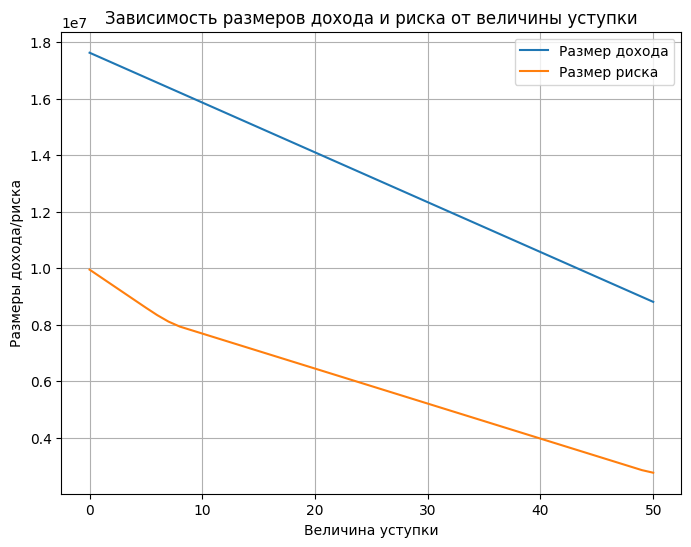

In [ ]:
import matplotlib.pyplot as plt

# Величина уступки от 0 до 50
ustupki = list(range(51))

# Построение графиков
plt.figure(figsize=(8, 6))

plt.plot(ustupki, income_arr, label='Размер дохода')
plt.plot(ustupki, risk_arr, label='Размер риска')

plt.xlabel('Величина уступки')
plt.ylabel('Размеры дохода/риска')

plt.title('Зависимость размеров дохода и риска от величины уступки')
plt.legend()

plt.grid(True)
plt.show()


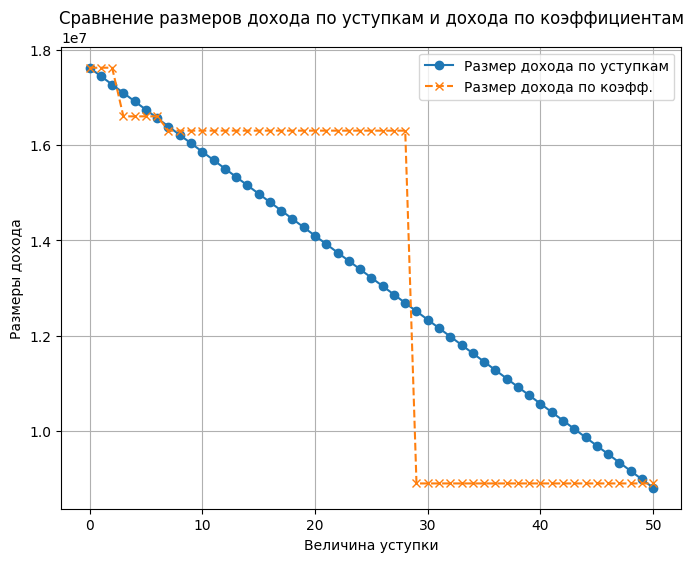

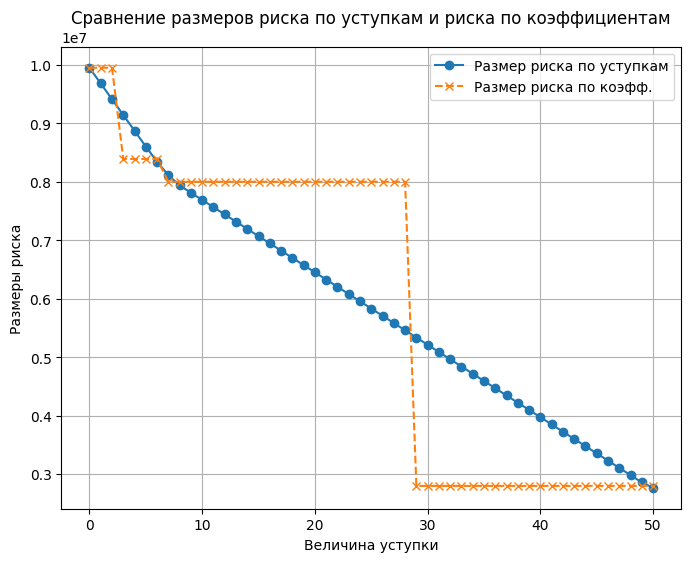

In [ ]:
import matplotlib.pyplot as plt

# Построение графика для размеров дохода
plt.figure(figsize=(8, 6))

plt.plot(ustupki, income_arr, label='Размер дохода по уступкам', linestyle='-', marker='o')
plt.plot(ustupki, coefs_income_arr, label='Размер дохода по коэфф.', linestyle='--', marker='x')

plt.xlabel('Величина уступки')
plt.ylabel('Размеры дохода')

plt.title('Сравнение размеров дохода по уступкам и дохода по коэффициентам')
plt.legend()

plt.grid(True)
plt.show()

# Построение графика для размеров риска
plt.figure(figsize=(8, 6))

plt.plot(ustupki, risk_arr, label='Размер риска по уступкам', linestyle='-', marker='o')
plt.plot(ustupki, coefs_risk_arr, label='Размер риска по коэфф.', linestyle='--', marker='x')

plt.xlabel('Величина уступки')
plt.ylabel('Размеры риска')

plt.title('Сравнение размеров риска по уступкам и риска по коэффициентам')
plt.legend()

plt.grid(True)
plt.show()


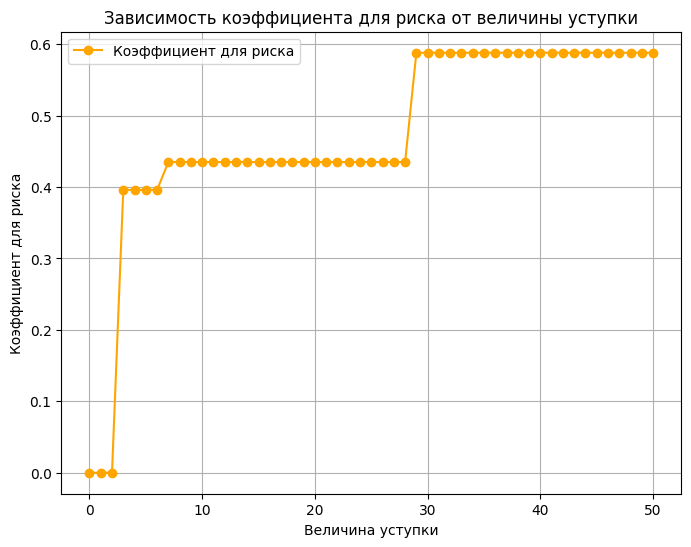

In [ ]:
import matplotlib.pyplot as plt

# Построение графика зависимости коэффициента для риска от величины уступки
plt.figure(figsize=(8, 6))

plt.plot(ustupki, coefs_arr, label='Коэффициент для риска', linestyle='-', marker='o', color='orange')

plt.xlabel('Величина уступки')
plt.ylabel('Коэффициент для риска')

plt.title('Зависимость коэффициента для риска от величины уступки')
plt.legend()

plt.grid(True)
plt.show()


Выводы:

В ходе работы были получены решения с различной величиной уступки, а также с различными весовыми коэффициентами, которые наилучшим образом приближают решение с заданной величиной уступки. Подбор величины уступки выглядит более естественным методом при условии, что мы не знаем в каком соотношении нам важны целевые функции. Благодаря методу уступок получаются более гладкие решения с меньшими временными и техническими затратами.